# Create Dummy Data with Faker
- by: Mohammad Isyroful Aqli | Sekolah Data Pacmann
- project: database design e-library app | November 2024

In [1]:
# Instalasi library Faker
!pip install Faker
!pip install tabulate

In [2]:
# Import library yang diperlukan
import random
from datetime import datetime, timedelta
from faker import Faker
import csv
import pandas as pd
from tabulate import tabulate

In [3]:
# Definisikan bahwa data yang digunakan menggunakan format Indonesia
fake = Faker('id_ID')

# Dummy Data tabel yang fokus untuk dibuat adalah sebagai berikut:
- tabel user
- tabel loan
- tabel hold
- tabel loan_limit

dengan relasi tabel seperti dibawah ini:
- user dengan loan - one to many
- user dengan hold - one to many
- user dengan loan_limit - one to one

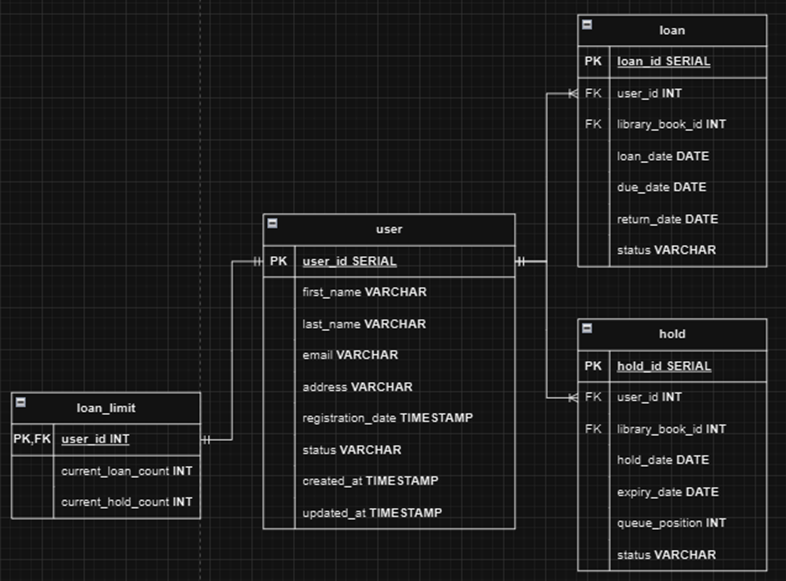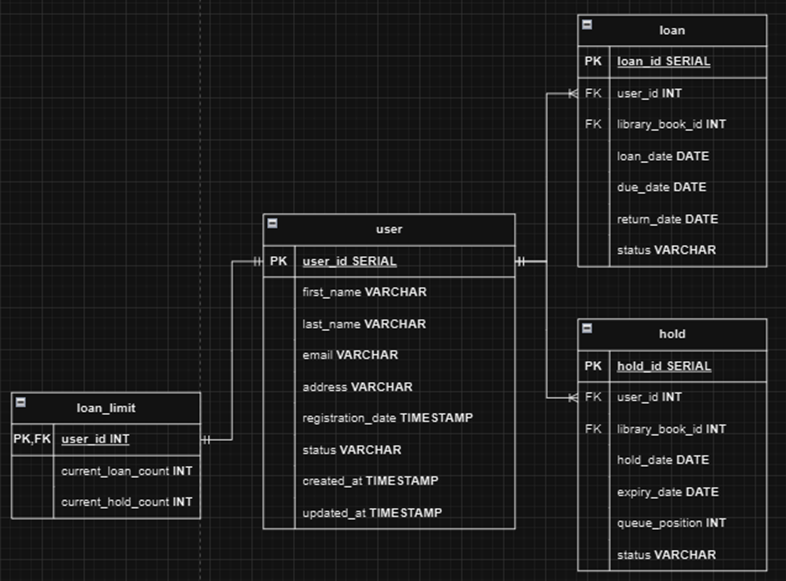

### sedangkan untuk tabel lainnya (library, book, category, book_category, dan library_book) sudah dibuat secara manual dengan format file CSV, analisa pertimbangan sebagai berikut:
- library untuk mendapatkan nama fake library pada faker tidak akurat dan menjadi nama yang tidak sesuai dengan library / nama perpustakaan pada umumnya
- book untuk mendapatkan nama fake buku pada faker tidak akurat dan menjadi nama buku yang tidak sesuai kenyataan yang ada, sehingga saya list secara manual buku yang best seller dan nama penulis yg sesuai
- category untuk mendapatkan genre category buku pada faker juga tidak akurat sehingga saya memilih jalan manual untuk menyesuaikan nama category yang mudah dikenali
- library_book dan book_category karena sifatnya tabel yang masih berhubungan dengan diatas maka saya buat manual agar sinkron dengan library, book, dan categorynya

In [4]:
# untuk melakukan generate tabel loan dan hold karena membutuhkan library_book_id maka saya gunakan id nya agar sinkron

# Read the CSV file with semicolon as the delimite
file_path = 'mentoring week 8 sql/library_book.csv'
df_library_books = pd.read_csv(file_path, delimiter=';')
library_book_ids = df_library_books['library_book_id'].unique().tolist()

In [6]:
# Tentukan rentang tanggal untuk data pengguna yang akan dibuat
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')

# Fungsi untuk menghasilkan data pengguna
def generate_users(num_users=50):
    users = []
    for i in range(1, num_users + 1):
        first_name = fake.first_name()
        last_name = fake.last_name()
        username = f"{first_name.lower()}{''.join(random.choices('0123456789', k=3))}"
        registration_date = fake.date_between(start_date=start_date, end_date=end_date)
        
        user = {
            'user_id': i,
            'first_name': first_name,
            'last_name': last_name,
            'username': username,
            'password': fake.password(length=12),
            'email': fake.email(),
            'registration_date': registration_date,
            'status': random.choice(['active', 'inactive']),
            'created_at': registration_date,
            'updated_at': fake.date_time_between(start_date=registration_date, end_date='now')
        }
        users.append(user)
    return users

# Fungsi untuk menghasilkan batas peminjaman per pengguna
def generate_loan_limits(users):
    loan_limits = []
    for user in users:
        loan_limit = {
            'user_id': user['user_id'],
            'max_loans': random.randint(1, 2),
            'max_holds': random.randint(1, 2)
        }
        loan_limits.append(loan_limit)
    return loan_limits

# Fungsi untuk membuat data pemesanan buku oleh pengguna
def generate_holds(users, num_holds=100):
    holds = []
    hold_id = 1
    
    for _ in range(num_holds):
        user = random.choice(users)
        hold_date = fake.date_time_between(start_date=user['registration_date'], end_date='now')
        
        if len([hold for hold in holds if hold['user_id'] == user['user_id'] and hold['status'] == 'active']) < 2:
            hold = {
                'hold_id': hold_id,
                'user_id': user['user_id'],
                'library_book_id': random.choice(library_book_ids),
                'hold_date': hold_date,
                'expiration_date': hold_date + timedelta(days=7),
                'queue_position': random.randint(1, 5),
                'status': random.choice(['active', 'expired', 'ready'])
            }
            holds.append(hold)
            hold_id += 1

    return holds

# Fungsi untuk membuat data peminjaman buku oleh pengguna
def generate_loans(users, num_loans=200):
    loans = []
    loan_id = 1
    
    for _ in range(num_loans):
        user = random.choice(users)
        loan_date = fake.date_time_between(start_date=user['registration_date'], end_date='now')
        due_date = loan_date + timedelta(days=14)
        
        if len([loan for loan in loans if loan['user_id'] == user['user_id'] and loan['status'] == 'borrowed']) < 2:
            loan = {
                'loan_id': loan_id,
                'user_id': user['user_id'],
                'library_book_id': random.choice(library_book_ids),
                'loan_date': loan_date,
                'due_date': due_date,
                'return_date': None if datetime.now() < due_date else fake.date_time_between(start_date=loan_date, end_date=due_date),
                'status': 'borrowed' if datetime.now() < due_date else 'overdue'
            }
            loans.append(loan)
            loan_id += 1

    return loans

# Fungsi untuk menyimpan data ke file CSV
def save_to_csv(data, filename):
    if data:
        keys = data[0].keys()
        with open(filename, 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows(data)

# Fungsi untuk menampilkan data dalam format tabulate
def display_data(data, title):
    if data:
        print(f"\n{title}")
        print(tabulate(data, headers="keys", tablefmt="grid"))
        print(f"Total {title.lower()}: {len(data)}")

# Fungsi utama yang mengatur semua proses pembuatan data
def main():
    # Menghasilkan data pengguna
    users = generate_users(50)
    
    # Menghasilkan data batas peminjaman per pengguna
    loan_limits = generate_loan_limits(users)
    
    # Menghasilkan data pemesanan (hold) untuk pengguna
    holds = generate_holds(users, 100)
    
    # Menghasilkan data peminjaman (loan) untuk pengguna
    loans = generate_loans(users, 200)
    
    # Menyimpan semua data ke file CSV
    save_to_csv(users, 'user.csv')
    save_to_csv(loan_limits, 'loan_limit.csv')
    save_to_csv(holds, 'hold.csv')
    save_to_csv(loans, 'loan.csv')
    
    print("\nData generation complete! Files have been created:")
    print("- user.csv")
    print("- loan_limit.csv")
    print("- hold.csv")
    print("- loan.csv")

# Memastikan fungsi main hanya dijalankan jika script ini dieksekusi langsung
if __name__ == "__main__":
    main()


Data generation complete! Files have been created:
- user.csv
- loan_limit.csv
- hold.csv
- loan.csv


In [8]:
# menampilkan data tabel user
users = generate_users(50)
display_data(users, "Users Data")


Users Data
+-----------+--------------+-------------+--------------+--------------+-------------------------------+---------------------+----------+--------------+----------------------------+
|   user_id | first_name   | last_name   | username     | password     | email                         | registration_date   | status   | created_at   | updated_at                 |
+===========+==============+=============+==============+==============+===============================+=====================+==========+==============+============================+
|         1 | Gamanto      | Uyainah     | gamanto204   | U)2VcwolB+Xf | edwardwulandari@example.org   | 2023-06-04          | active   | 2023-06-04   | 2024-08-29 15:25:24        |
+-----------+--------------+-------------+--------------+--------------+-------------------------------+---------------------+----------+--------------+----------------------------+
|         2 | Zamira       | Megantara   | zamira548    | ye41E#sSmW$$ | dono9

In [9]:
# menampilkan data tabel loan_limits
loan_limits = generate_loan_limits(users)
display_data(loan_limits, "Loan Limits Data")


Loan Limits Data
+-----------+-------------+-------------+
|   user_id |   max_loans |   max_holds |
+===========+=============+=============+
|         1 |           2 |           1 |
+-----------+-------------+-------------+
|         2 |           2 |           2 |
+-----------+-------------+-------------+
|         3 |           1 |           2 |
+-----------+-------------+-------------+
|         4 |           2 |           1 |
+-----------+-------------+-------------+
|         5 |           1 |           1 |
+-----------+-------------+-------------+
|         6 |           1 |           1 |
+-----------+-------------+-------------+
|         7 |           1 |           1 |
+-----------+-------------+-------------+
|         8 |           1 |           1 |
+-----------+-------------+-------------+
|         9 |           2 |           2 |
+-----------+-------------+-------------+
|        10 |           1 |           1 |
+-----------+-------------+-------------+
|        11 |   

In [10]:
# menampilkan data tabel hold
holds = generate_holds(users, 100)
display_data(holds, "Holds Data")


Holds Data
+-----------+-----------+-------------------+----------------------------+----------------------------+------------------+----------+
|   hold_id |   user_id |   library_book_id | hold_date                  | expiration_date            |   queue_position | status   |
+===========+===========+===================+============================+============================+==================+==========+
|         1 |        25 |                 7 | 2024-04-05 20:26:25        | 2024-04-12 20:26:25        |                1 | ready    |
+-----------+-----------+-------------------+----------------------------+----------------------------+------------------+----------+
|         2 |        22 |                75 | 2024-02-18 14:25:15        | 2024-02-25 14:25:15        |                5 | active   |
+-----------+-----------+-------------------+----------------------------+----------------------------+------------------+----------+
|         3 |        37 |                88 | 2024

In [11]:
# menampilkan data tabel loan
loans = generate_loans(users, 200)
display_data(loans, "Loans Data")


Loans Data
+-----------+-----------+-------------------+----------------------------+----------------------------+---------------------+----------+
|   loan_id |   user_id |   library_book_id | loan_date                  | due_date                   | return_date         | status   |
+===========+===========+===================+============================+============================+=====================+==========+
|         1 |        40 |                71 | 2024-09-22 17:36:20        | 2024-10-06 17:36:20        | 2024-09-30 14:17:26 | overdue  |
+-----------+-----------+-------------------+----------------------------+----------------------------+---------------------+----------+
|         2 |        24 |                21 | 2024-05-25 21:03:48        | 2024-06-08 21:03:48        | 2024-06-08 08:06:51 | overdue  |
+-----------+-----------+-------------------+----------------------------+----------------------------+---------------------+----------+
|         3 |        38 |    